## Baseline model 

As a baseline model we will use ResNet 18, first with its pre-trained weights

Source: https://www.pluralsight.com/resources/blog/guides/introduction-to-resnet

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report

## Data preprocessing

In [7]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])


In [8]:
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In [9]:
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index

{'Start/Restar the game': 0,
 'The joy of the players': 1,
 'yellow card': 2,
 'Red Card': 3,
 'Stadium View': 4,
 'Penalty Image': 5,
 'Free Kick': 6,
 'Generic Moment': 7}

In [10]:
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)


In [11]:
labels['label'].value_counts()

label
4    3209
6    2020
7    2009
1    1329
2     586
5     452
0     325
3      70
Name: count, dtype: int64

In [12]:
labels = labels.drop(columns=LABELS)

In [13]:
# ==== Config ====
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [14]:
class MatchDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, str(row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)
        return image, label


We first split the data in train, val and test, and then we preprocess them normalizing with the predefined Resnet method

In [15]:
# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ==== Load Data ====
image_path = 'data/selected_images'
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_dataset_prep = MatchDataset(train_dataset, image_path, transform)
test_dataset_prep = MatchDataset(test_dataset, image_path, transform)
val_dataset_prep = MatchDataset(val_dataset, image_path, transform)


train_loader = DataLoader(train_dataset_prep, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_prep, batch_size=batch_size)
test_loader = DataLoader(test_dataset_prep, batch_size=batch_size)


In [17]:
# ==== Model ====
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# ==== Training Loop ====
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total * 100
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'resnet18_football_best.pth')
        print("✅ Saved new best model.")

print("Training complete.")

[1/10] Train Loss: 0.8631, Acc: 69.81%, Val Loss: 1.1764, Acc: 56.06%
✅ Saved new best model.
[2/10] Train Loss: 0.5795, Acc: 79.86%, Val Loss: 0.6988, Acc: 73.69%
✅ Saved new best model.
[3/10] Train Loss: 0.4564, Acc: 84.09%, Val Loss: 0.7249, Acc: 76.19%
[4/10] Train Loss: 0.3515, Acc: 88.08%, Val Loss: 0.5429, Acc: 82.75%
✅ Saved new best model.
[5/10] Train Loss: 0.2865, Acc: 90.50%, Val Loss: 0.8169, Acc: 75.06%
[6/10] Train Loss: 0.2083, Acc: 92.72%, Val Loss: 1.2719, Acc: 73.31%
[7/10] Train Loss: 0.2038, Acc: 93.19%, Val Loss: 0.5659, Acc: 82.12%
[8/10] Train Loss: 0.1591, Acc: 94.72%, Val Loss: 0.6013, Acc: 83.06%
[9/10] Train Loss: 0.1130, Acc: 96.03%, Val Loss: 0.7141, Acc: 81.44%
[10/10] Train Loss: 0.0927, Acc: 96.80%, Val Loss: 1.0835, Acc: 79.94%
Training complete.


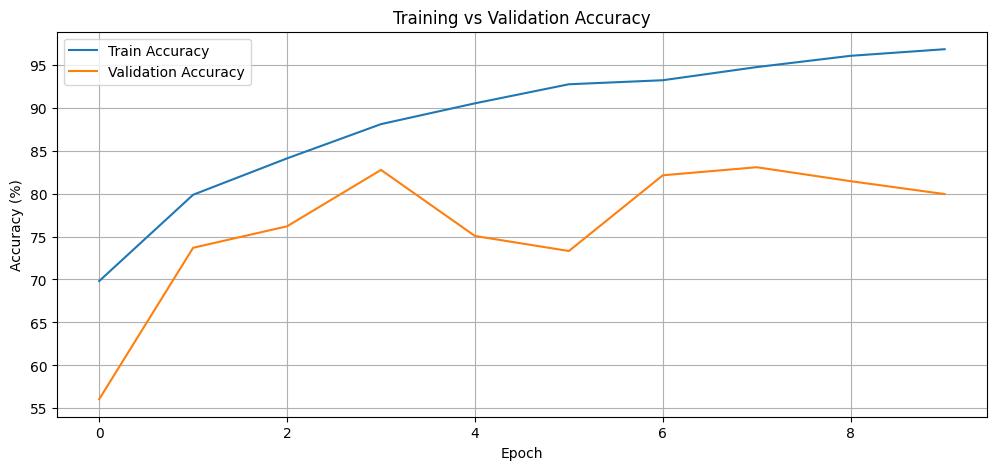

In [27]:
# ==== Accuracy Plot ====
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.title("Training vs Validation Accuracy")
plt.show()

### Confusion matrix

In [18]:
# ==== Load Best Model ====
model.load_state_dict(torch.load('resnet18_football_best.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:

# ==== Inference on Test Set ====
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [31]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.942     0.766     0.845        64
The joy of the players      0.708     0.860     0.777       257
           yellow card      0.876     0.861     0.868       115
              Red Card      0.875     0.538     0.667        13
          Stadium View      0.832     0.944     0.884       660
         Penalty Image      0.859     0.847     0.853        72
             Free Kick      0.881     0.789     0.832       431
        Generic Moment      0.748     0.595     0.663       388

              accuracy                          0.816      2000
             macro avg      0.840     0.775     0.799      2000
          weighted avg      0.818     0.816     0.812      2000



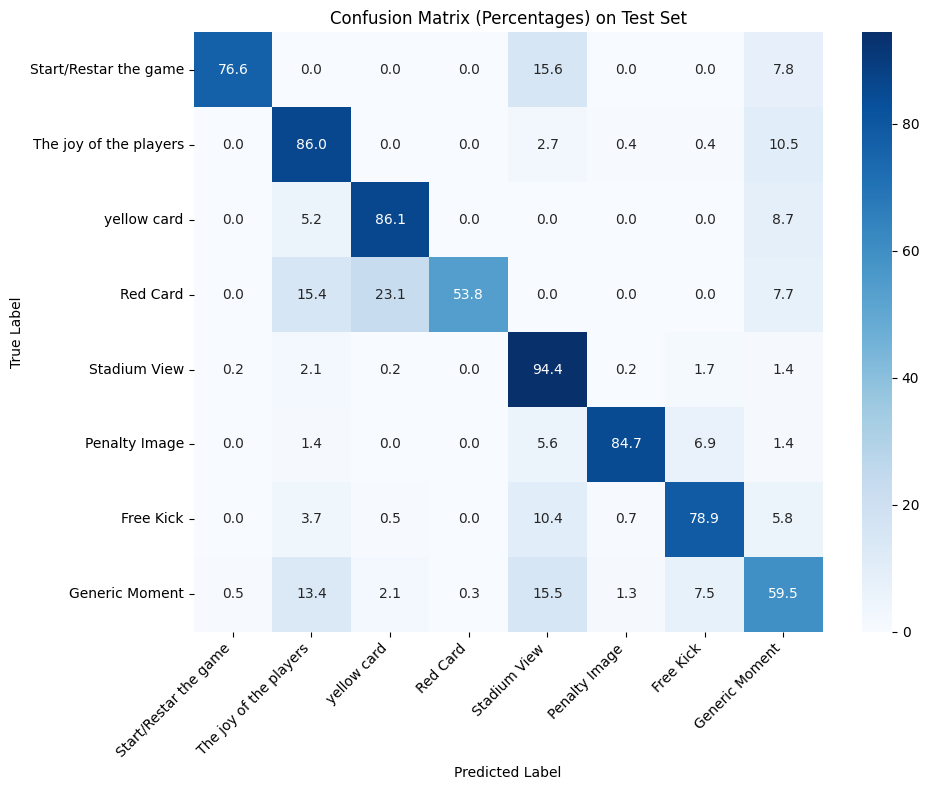

In [32]:
# ==== Compute Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
import numpy as np

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Print per-class accuracy as table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}%")


Class                      Accuracy
-----------------------------------
Start/Restar the game        76.56%
The joy of the players       85.99%
yellow card                  86.09%
Red Card                     53.85%
Stadium View                 94.39%
Penalty Image                84.72%
Free Kick                    78.89%
Generic Moment               59.54%


---

## Attention map (?) visualization

vedere CNN su drive di lomurno e vedere aree delle immagini che si attivano quando fa inference 

In [25]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Set backend for headless servers
import matplotlib
matplotlib.use('Agg')


In [26]:
def extract_activations_simple(model, input_tensor):
    
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.clone()
        return hook
    
    handle1 = model.conv1.register_forward_hook(get_activation('first_conv'))
    handle2 = model.layer4[1].conv2.register_forward_hook(get_activation('last_conv'))
    
    # Forward pass
    model.eval()
    output = model(input_tensor)
    
    # Remove hooks
    handle1.remove()
    handle2.remove()
    
    return activations.get('first_conv'), activations.get('last_conv'), output


In [27]:
def visualize_football_simple(model, test_loader, device, save_path='activ_map.png'):
    
    # Get sample
    input_tensor, labels = next(iter(test_loader))
    image = input_tensor[0].unsqueeze(0).to(device)
    true_label = labels[0].item()
    
    # Extract activations
    first_acts, last_acts, output = extract_activations_simple(model, image)
    
    # Get prediction
    probabilities = F.softmax(output[0], dim=0)
    predicted_class = torch.argmax(output[0]).item()
    confidence = probabilities[predicted_class].item()
    
    # Denormalize image
    denorm = input_tensor[0].clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = denorm * std + mean
    denorm = torch.clamp(denorm, 0, 1).permute(1, 2, 0).numpy()
    
    # Create simple visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Original image
    axes[0, 0].imshow(denorm)
    axes[0, 0].set_title(f'Original\nTrue: {LABELS[true_label]}\nPred: {LABELS[predicted_class]}\nConf: {confidence:.3f}')
    axes[0, 0].axis('off')
    
    # First conv activations (first 3 filters)
    if first_acts is not None:
        first_np = first_acts[0].detach().cpu().numpy()
        for i in range(3):
            if i < first_np.shape[0]:
                activation = first_np[i]
                activation = (activation - activation.min()) / (activation.max() - activation.min())
                axes[0, i+1].imshow(activation, cmap='viridis')
                axes[0, i+1].set_title(f'First Conv Filter {i+1}')
                axes[0, i+1].axis('off')
    
    # Last conv activations (first 4 filters)
    if last_acts is not None:
        last_np = last_acts[0].detach().cpu().numpy()
        for i in range(4):
            if i < last_np.shape[0]:
                activation = last_np[i]
                activation = (activation - activation.min()) / (activation.max() - activation.min())
                # Resize for better view
                activation_resized = F.interpolate(
                    torch.from_numpy(activation).unsqueeze(0).unsqueeze(0),
                    size=(56, 56), mode='bilinear', align_corners=False
                ).squeeze().numpy()
                axes[1, i].imshow(activation_resized, cmap='hot')
                axes[1, i].set_title(f'Last Conv Filter {i+1}')
                axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved to: {save_path}")
    
    # Print results
    print(f"True: {LABELS[true_label]}")
    print(f"Pred: {LABELS[predicted_class]} ({confidence:.3f})")
    print(f"Correct: {'✓' if predicted_class == true_label else '✗'}")


In [28]:
visualize_football_simple(model, test_loader, device)

Saved to: activ_map.png
True: Free Kick
Pred: Free Kick (0.995)
Correct: ✓
